In [12]:
#!conda install pytorch
#!conda install Pillow
#!conda install scikit-image
#conda install -c conda-forge opencv
#conda install -c conda-forge keras
#conda install -c conda-forge tensorflow

In [1]:
import json
import numpy as np
import time 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder


Setting up GPU for caluculations

In [ ]:
#conda create --name tf_gpu tensorflow-gpu 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


Converting the JSON file to a Pandas dataframe but dropping image 4215425.jpg as this was corrupted

Setting up the paths to the files. 

Changing the images so Inception V3 can read them 

How Inception V3 sees images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

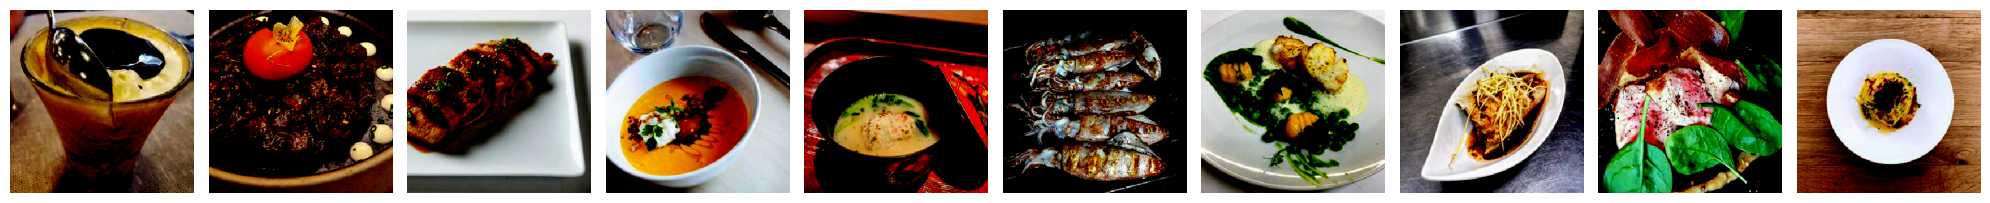

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [3]:
imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

## InceptionV3 model

In [24]:
train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=train_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10)
test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)
valid_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)

# Setting weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


In [25]:
#Set up values
epochs = 10
input_shape=(299,299,3)
batch_size=32
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense']

In [26]:
from tensorflow.keras.callbacks import TensorBoard
import time
import datetime


dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME= f"{conv_layer}-conv-{layer_size}-nodes-{dense_layer}-dense-{int(time.time())}"

            # Set up TensorBoard
            log_dir = f"logs/fit/{NAME}"
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

            # Load the InceptionV3 model
            inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

            # Freeze the earlier layers of InceptionV3
            for layer in inceptionv3.layers[:-17]:
                layer.trainable = False
            # Fine-tune the last two inception blocks of InceptionV3
            for layer in inceptionv3.layers[-17:]:
                layer.trainable = True

            # Build a classifier on top of the InceptionV3 model with additional layers
            model= Sequential()
            model.add(inceptionv3)

            for l in range(conv_layer):
                model.add(Conv2D(filters=layer_size, kernel_size=(3, 3), padding='same'))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))  

            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(units=layer_size))
                model.add(Activation('relu'))
            
            model.add(Dense(units=4))
            model.add(Activation('softmax'))

            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
                    callbacks=[reduce_lr, tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                   #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                  #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                  )

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
classes=classes)


# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/10
1773/1773 [==============================] - 68s 36ms/step - loss: 1.3154 - accuracy: 0.3468 - val_loss: 1.3401 - val_accuracy: 0.3470
Epoch 2/10
1773/1773 [==============================] - 55s 31ms/step - loss: 1.2317 - accuracy: 0.3958 - val_loss: 1.3047 - val_accuracy: 0.3525
Epoch 3/10
1773/1773 [==============================] - 56s 31ms/step - loss: 1.1522 - accuracy: 0.4406 - val_loss: 1.3198 - val_accuracy: 0.3536
Epoch 4/10
1587/1773 [=========================>....] - ETA: 4s - loss: 1.0178 - accuracy: 0.4983

In [ ]:
#tensorboard --logdir=C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\logs\fit

Graphical plot of loss and accuracy in training and test set 

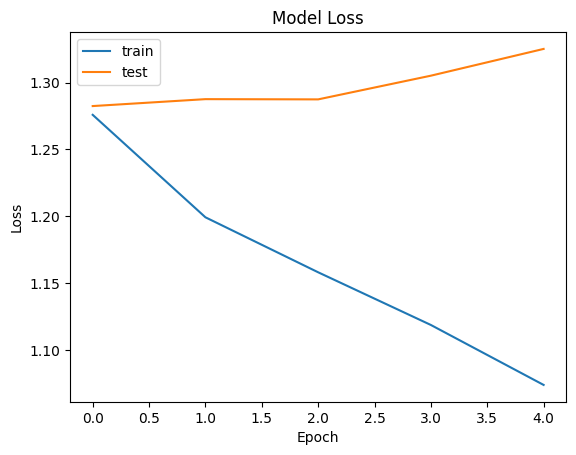

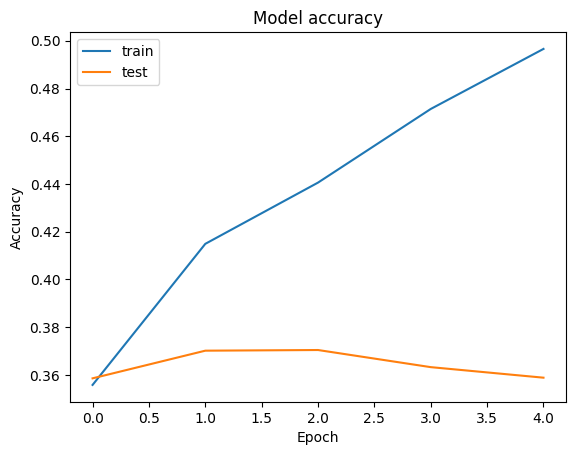

In [13]:
# Plot the loss and validation loss over epochs
plt.plot(InceptionV3_model.history['loss'], label='train')
plt.plot(InceptionV3_model.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(InceptionV3_model.history['accuracy'], label='train')
plt.plot(InceptionV3_model.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### only using 2 classes

In [70]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

# Define a callback to print the learning rate after every epoch
class LRPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy()
        print(f'Learning rate: {lr}')

# Set up values
epochs = 10
input_shape=(299,299,3)
batch_size=32
classes=['On a budget', 'Spare no expense']

# Load the InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of InceptionV3
for layer in inceptionv3.layers[:-17]:
    layer.trainable = False

# Fine-tune the last two inception blocks of InceptionV3
for layer in inceptionv3.layers[-17:]:
    layer.trainable = True

# Build a classifier on top of the InceptionV3 model with additional layers
model = Sequential([
    inceptionv3,
    Conv2D(filters=128, kernel_size=(5, 5), padding='same'),
    Activation('relu'),
    Conv2D(filters=128, kernel_size=(5, 5), padding='same'),
    Activation('relu'),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    GlobalAveragePooling2D(),
    
    Flatten(),
    Dense(units=1024),
    Dense(units=512),
    Dense(units=2),
    Activation('softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


# Setting weights
class_indices = train_batch.class_indices
num_classes = len(classes)
total_samples = train_batch.samples
class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
classes=classes)


# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
lr_printer = LRPrinter()

binary_model = model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
                    callbacks=[reduce_lr, lr_printer], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))



# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Found 7541 images belonging to 2 classes.
Found 1623 images belonging to 2 classes.
Found 274 images belonging to 2 classes.
Epoch 1/10
236/236 [==============================] - 25s 90ms/step - loss: 0.5762 - accuracy: 0.6368 - val_loss: 0.5168 - val_accuracy: 0.7548
Learning rate: 9.999999747378752e-06
Epoch 2/10
236/236 [==============================] - 20s 86ms/step - loss: 0.4703 - accuracy: 0.7931 - val_loss: 0.4934 - val_accuracy: 0.7739
Learning rate: 9.999999747378752e-06
Epoch 3/10
236/236 [==============================] - 21s 87ms/step - loss: 0.4470 - accuracy: 0.8018 - val_loss: 0.4998 - val_accuracy: 0.7634
Learning rate: 9.999999747378752e-06
Epoch 4/10
236/236 [==============================] - 21s 87ms/step - loss: 0.4064 - accuracy: 0.8276 - val_loss: 0.4915 - val_accuracy: 0.7782
Learning rate: 9.999999747378752e-06
Epoch 5/10
236/236 [==============================] - 20s 86ms/step - loss: 0.3762 - accuracy: 0.8417 - val_loss: 0.5023 - val_accuracy: 0.7677
Learnin

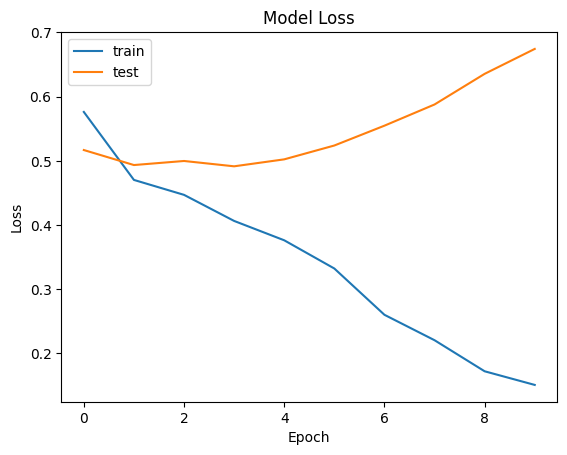

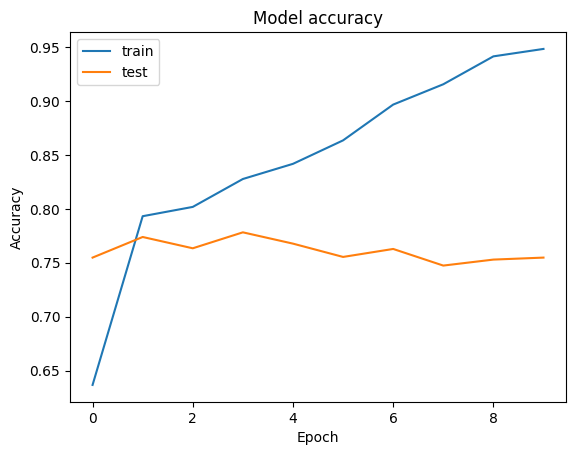

In [71]:
# Plot the loss and validation loss over epochs
plt.plot(binary_model.history['loss'], label='train')
plt.plot(binary_model.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(binary_model.history['accuracy'], label='train')
plt.plot(binary_model.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Using the DenseNet 201 model 

In [18]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up values
epochs = 10
input_shape=(224,224,3)
batch_size=32

# Load the DenseNet201 model
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of DenseNet201
for layer in densenet201.layers[:-15]:
    layer.trainable = False

# Fine-tune the last three dense blocks of DenseNet201
for layer in densenet201.layers[-15:]:
    layer.trainable = True

# Build a classifier on top of the DenseNet201 model with additional layers
model = Sequential([
    densenet201,
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(units=64),
    Dense(units=4),
    Activation('softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'])

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
subset='training',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'],
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(224, 224),
batch_size=batch_size,
class_mode='categorical',
classes=['On a budget', 'Moderate spend', 'Special occasion', 'Spare no expense'])

# Train the model and save the history
DenseNet_model = model.fit(train_batch, epochs=epochs, validation_data=test_batch)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.
Epoch 1/10
554/554 [==============================] - 217s 369ms/step - loss: 1.2762 - accuracy: 0.3755 - val_loss: 1.3029 - val_accuracy: 0.3842
Epoch 2/10
554/554 [==============================] - 199s 358ms/step - loss: 1.2116 - accuracy: 0.4267 - val_loss: 1.3005 - val_accuracy: 0.3743
Epoch 3/10
554/554 [==============================] - 197s 355ms/step - loss: 1.1856 - accuracy: 0.4371 - val_loss: 1.2942 - val_accuracy: 0.3723
Epoch 4/10
554/554 [==============================] - 199s 359ms/step - loss: 1.1572 - accuracy: 0.4599 - val_loss: 1.3159 - val_accuracy: 0.3856
Epoch 5/10
554/554 [==============================] - 199s 358ms/step - loss: 1.1275 - accuracy: 0.4790 - val_loss: 1.2902 - val_accuracy: 0.3834
Epoch 6/10
554/554 [==============================] - 197s 356ms/step - loss: 1.0984 - accuracy: 0.4916 - val_loss: 1.3185 - val_accuracy: 0.360

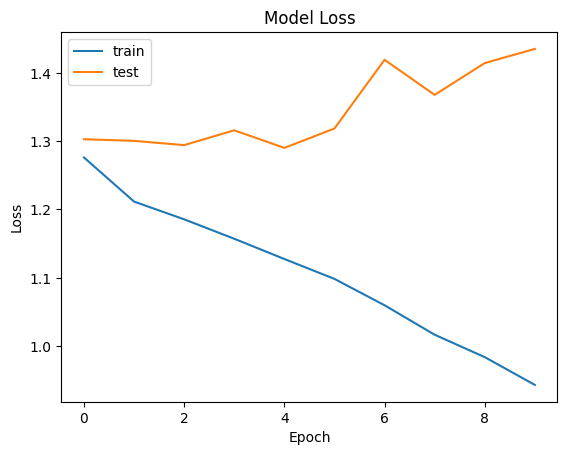

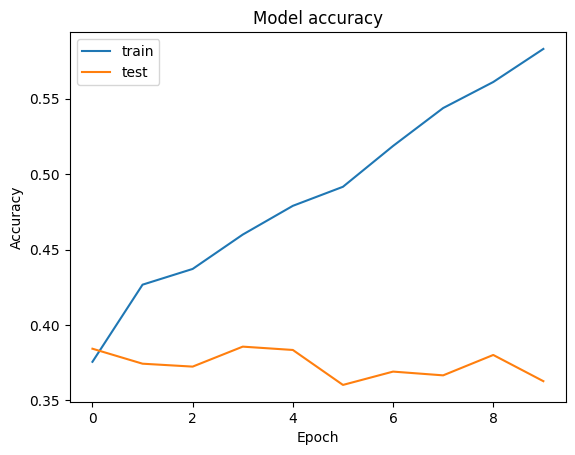

In [19]:
# Plot the loss and validation loss over epochs
plt.plot(DenseNet_model.history['loss'], label='train')
plt.plot(DenseNet_model.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(DenseNet_model.history['accuracy'], label='train')
plt.plot(DenseNet_model.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Exporting the model. 

In [10]:
# Save Weight model
model.save_weights("model1.h5")